# 🕸️ Bayesian Networks on Latent Space vs Original Features
## Comparing Two Approaches for Probabilistic Position Prediction

This notebook implements and compares:

### 🎯 **Option A: Discretized Latent Space BN**
- Discretize 4D latent vectors into bins (low, medium, high)
- 3^4 = 81 combinations (manageable for 240 samples)
- Tests if latent space captures causal structure

### 🎯 **Option B: Original Features BN (Classical)**
- Use categorical/discrete features (grid_pos, driver_category, team, etc.)
- More interpretable (direct feature relationships)
- Standard Bayesian Network approach

### 📊 **Comparison Metrics:**
- Structure learning quality (BIC score)
- Prediction accuracy (R², MAE, position distribution)
- Interpretability (network structure, conditional probabilities)
- Inference speed

---

## 📦 Step 1: Import Libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder
import torch
import glob
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Bayesian Network libraries
try:
    # Try importing DiscreteBayesianNetwork (newer) or BayesianNetwork (older)
    try:
        from pgmpy.models import DiscreteBayesianNetwork as BayesianNetwork
    except ImportError:
        from pgmpy.models import BayesianNetwork
    
    from pgmpy.estimators import MaximumLikelihoodEstimator, HillClimbSearch
    from pgmpy.inference import VariableElimination
    
    # Try importing scoring methods (newer pgmpy uses BIC/K2, older uses BicScore/K2Score)
    try:
        from pgmpy.estimators import BIC as BicScore, K2 as K2Score
    except ImportError:
        try:
            from pgmpy.estimators import BicScore, K2Score
        except ImportError:
            from pgmpy.estimators.StructureScore import BicScore, K2Score
    
    print("✅ pgmpy installed successfully!")
except ImportError as e:
    print(f"❌ pgmpy not installed. Installing now... Error: {e}")
    import subprocess
    subprocess.check_call(['pip', 'install', 'pgmpy'])
    
    # Try importing DiscreteBayesianNetwork (newer) or BayesianNetwork (older)
    try:
        from pgmpy.models import DiscreteBayesianNetwork as BayesianNetwork
    except ImportError:
        from pgmpy.models import BayesianNetwork
    
    from pgmpy.estimators import MaximumLikelihoodEstimator, HillClimbSearch
    from pgmpy.inference import VariableElimination
    
    # Try importing scoring methods
    try:
        from pgmpy.estimators import BIC as BicScore, K2 as K2Score
    except ImportError:
        try:
            from pgmpy.estimators import BicScore, K2Score
        except ImportError:
            from pgmpy.estimators.StructureScore import BicScore, K2Score
    
    print("✅ pgmpy installed and imported!")

print("\n✅ All libraries imported successfully!")
print("="*80)

✅ pgmpy installed successfully!

✅ All libraries imported successfully!


## 📂 Step 2: Load Data (Latent Vectors + Original Features)

In [12]:
print("📂 Loading data for both approaches...\n")
print("="*80)

# ============================================================================
# OPTION A: Load VAE Latent Vectors (4D)
# ============================================================================
latent_files = glob.glob('data/preprocessed/vae_latent_OPTIMIZED_*.csv')
if not latent_files:
    raise FileNotFoundError("❌ No VAE latent vectors found! Please run notebook 04 first.")

latest_latent = max(latent_files, key=os.path.getctime)
latent_data = pd.read_csv(latest_latent)

print(f"✅ Latent Vectors: {os.path.basename(latest_latent)}")
print(f"   Samples: {len(latent_data)}")
print(f"   Columns: {list(latent_data.columns)}")

# ============================================================================
# OPTION B: Load Original Engineered Features
# ============================================================================
engineered_files = glob.glob('data/preprocessed/singapore_engineered_*.csv')
if not engineered_files:
    raise FileNotFoundError("❌ No engineered features found! Please run notebook 03 first.")

latest_engineered = max(engineered_files, key=os.path.getctime)
original_data = pd.read_csv(latest_engineered)

print(f"\n✅ Original Features: {os.path.basename(latest_engineered)}")
print(f"   Samples: {len(original_data)}")
print(f"   Features: {len(original_data.columns)}")

# Check alignment
if len(latent_data) != len(original_data):
    print(f"\n⚠️ WARNING: Sample count mismatch! Latent={len(latent_data)}, Original={len(original_data)}")
else:
    print(f"\n✅ Data aligned: {len(latent_data)} samples in both datasets")

print("="*80)

📂 Loading data for both approaches...

✅ Latent Vectors: vae_latent_OPTIMIZED_20251026_234217.csv
   Samples: 240
   Columns: ['latent_dim_0', 'latent_dim_1', 'latent_dim_2', 'latent_dim_3', 'finish_pos', 'pos_predicted']

✅ Original Features: singapore_engineered_20251026_234139.csv
   Samples: 240
   Features: 41

✅ Data aligned: 240 samples in both datasets


---
# 🅰️ OPTION A: Bayesian Network on Discretized Latent Space
---

## 🔢 Step 3A: Discretize Latent Dimensions into Bins

In [13]:
print("🔢 OPTION A: Discretizing 4D latent space into bins...\n")
print("="*80)

# Extract latent dimensions
latent_cols = [col for col in latent_data.columns if 'latent_dim' in col]
X_latent = latent_data[latent_cols].values
y_latent = latent_data['finish_pos'].values

print(f"📊 Latent Space:")
print(f"   Dimensions: {X_latent.shape[1]}D")
print(f"   Samples: {X_latent.shape[0]}")
print(f"   Latent ranges:")
for i, col in enumerate(latent_cols):
    print(f"      {col}: [{X_latent[:, i].min():.3f}, {X_latent[:, i].max():.3f}]")

# ============================================================================
# Discretize each latent dimension into 3 bins: low, medium, high
# ============================================================================
n_bins = 3
discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
X_latent_discrete = discretizer.fit_transform(X_latent)

print(f"\n✅ Discretization Complete:")
print(f"   Bins per dimension: {n_bins} (low=0, medium=1, high=2)")
print(f"   Total combinations: {n_bins}^{X_latent.shape[1]} = {n_bins**X_latent.shape[1]}")
print(f"   Strategy: quantile (equal-sized bins)")

# Create dataframe for Bayesian Network
bn_latent_df = pd.DataFrame(
    X_latent_discrete, 
    columns=[f'latent_{i}_bin' for i in range(X_latent.shape[1])]
)
bn_latent_df = bn_latent_df.astype(int)  # pgmpy requires integers

# Discretize target (position) into categories
# Bins: Podium (1-3), Points (4-10), Midfield (11-15), Backmarker (16-20)
position_bins = [0, 3, 10, 15, 20]
position_labels = [0, 1, 2, 3]  # Podium=0, Points=1, Midfield=2, Backmarker=3
bn_latent_df['position_category'] = pd.cut(y_latent, bins=position_bins, labels=position_labels, include_lowest=True).astype(int)

# Remove any rows with NaN in position_category
bn_latent_df = bn_latent_df.dropna()

# ============================================================================
# Add driver names from original data (for driver-specific predictions)
# ============================================================================
print(f"\n🔗 Linking driver names to latent data...")
if 'driver_name' in original_data.columns:
    # Both datasets should have same number of rows and same order
    if len(latent_data) == len(original_data):
        # Add driver_name to latent_data for future use
        latent_data['driver_name'] = original_data['driver_name'].values
        # Add to bn_latent_df as well (before any dropna)
        bn_latent_df['driver_name'] = original_data['driver_name'].values[:len(bn_latent_df)]
        print(f"   ✅ Added driver names: {bn_latent_df['driver_name'].nunique()} unique drivers")
    else:
        print(f"   ⚠️ Size mismatch: latent={len(latent_data)}, original={len(original_data)}")
        print(f"   ⚠️ Cannot link driver names reliably")
else:
    print(f"   ⚠️ No driver_name column in original_data")

print(f"\n✅ Position Categories:")
print(f"   0 = Podium (1-3): {(bn_latent_df['position_category'] == 0).sum()} samples")
print(f"   1 = Points (4-10): {(bn_latent_df['position_category'] == 1).sum()} samples")
print(f"   2 = Midfield (11-15): {(bn_latent_df['position_category'] == 2).sum()} samples")
print(f"   3 = Backmarker (16-20): {(bn_latent_df['position_category'] == 3).sum()} samples")

print(f"\n📋 Final BN Dataset (Option A):")
print(bn_latent_df.head())
print(f"\n   Shape: {bn_latent_df.shape}")
print(f"   Columns: {list(bn_latent_df.columns)}")
print("="*80)


🔢 OPTION A: Discretizing 4D latent space into bins...

📊 Latent Space:
   Dimensions: 4D
   Samples: 240
   Latent ranges:
      latent_dim_0: [-0.136, 4.362]
      latent_dim_1: [-4.147, 0.830]
      latent_dim_2: [-1.073, 5.431]
      latent_dim_3: [-3.738, 0.680]

✅ Discretization Complete:
   Bins per dimension: 3 (low=0, medium=1, high=2)
   Total combinations: 3^4 = 81
   Strategy: quantile (equal-sized bins)

🔗 Linking driver names to latent data...
   ✅ Added driver names: 30 unique drivers

✅ Position Categories:
   0 = Podium (1-3): 37 samples
   1 = Points (4-10): 84 samples
   2 = Midfield (11-15): 60 samples
   3 = Backmarker (16-20): 59 samples

📋 Final BN Dataset (Option A):
   latent_0_bin  latent_1_bin  latent_2_bin  latent_3_bin  position_category  \
0             2             0             2             1                  3   
1             1             1             1             1                  2   
2             2             0             2             0    

## 🏗️ Step 4A: Learn Bayesian Network Structure (Latent Space)

In [14]:
print("🏗️ OPTION A: Learning Bayesian Network structure from latent space...\n")
print("="*80)

# Train/validation split (same as other notebooks)
bn_latent_train, bn_latent_val = train_test_split(
    bn_latent_df, 
    test_size=0.2, 
    random_state=42,
    stratify=bn_latent_df['position_category']
)

print(f"📊 Split Summary:")
print(f"   Training: {len(bn_latent_train)} samples")
print(f"   Validation: {len(bn_latent_val)} samples")

# ============================================================================
# Select only BN features (exclude driver_name - it's just for indexing)
# ============================================================================
bn_features = [col for col in bn_latent_train.columns if col != 'driver_name']
print(f"\n📋 BN Features: {bn_features}")

bn_latent_train_bn = bn_latent_train[bn_features].copy()
bn_latent_val_bn = bn_latent_val[bn_features].copy()

# ============================================================================
# Structure Learning: Hill Climbing with K2 Score (less conservative than BIC)
# ============================================================================
print(f"\n🔍 Learning structure with Hill Climbing (K2 scoring)...")
print(f"   K2 score is less conservative than BIC - encourages more edges")

# Use K2 score for better edge discovery with sufficient data
k2_score = K2Score(bn_latent_train_bn)
hc_search = HillClimbSearch(bn_latent_train_bn)

# Learn structure with more freedom to add edges (K2 is less conservative than BIC)
latent_bn_structure = hc_search.estimate(
    scoring_method=k2_score,
    max_iter=1000,
    show_progress=False
)

print(f"\n✅ Structure Learning Complete!")
print(f"   Nodes: {latent_bn_structure.nodes()}")
print(f"   Edges: {latent_bn_structure.edges()}")
print(f"   Number of edges: {len(latent_bn_structure.edges())}")
print(f"   Max possible edges (5 nodes DAG): ~10")
print(f"   Edge density: {len(latent_bn_structure.edges())/10*100:.1f}%")

# Calculate both K2 and BIC scores for comparison
final_k2 = k2_score.score(latent_bn_structure)
final_bic = BicScore(bn_latent_train_bn).score(latent_bn_structure)
print(f"\n📊 Model Quality:")
print(f"   K2 Score: {final_k2:.2f} (higher is better)")
print(f"   BIC Score: {final_bic:.2f} (for comparison)")

# ============================================================================
# Parameter Learning: Maximum Likelihood Estimation
# ============================================================================
print(f"\n📚 Fitting parameters with Maximum Likelihood Estimation...")

latent_bn_model = BayesianNetwork(latent_bn_structure.edges())
latent_bn_model.fit(
    bn_latent_train_bn,
    estimator=MaximumLikelihoodEstimator
)

print(f"✅ Model fitted successfully!")
print(f"   CPDs (Conditional Probability Distributions): {len(latent_bn_model.get_cpds())}")

# Check model validity
assert latent_bn_model.check_model(), "❌ Model is invalid!"
print(f"   Model validity: ✅ PASSED")

print("="*80)


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'latent_0_bin': 'N', 'latent_1_bin': 'N', 'latent_2_bin': 'N', 'latent_3_bin': 'N', 'position_category': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'latent_0_bin': 'N', 'latent_1_bin': 'N', 'latent_2_bin': 'N', 'latent_3_bin': 'N', 'position_category': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'latent_0_bin': 'N', 'latent_1_bin': 'N', 'latent_2_bin': 'N', 'latent_3_bin': 'N', 'position_category': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'latent_0_bin': 'N', 'latent_1_bin': 'N', 'latent_2_bin': 'N', 'latent_3_bin': 'N', 'position_category': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'latent_0_bin': 'N', 'latent_1

🏗️ OPTION A: Learning Bayesian Network structure from latent space...

📊 Split Summary:
   Training: 192 samples
   Validation: 48 samples

📋 BN Features: ['latent_0_bin', 'latent_1_bin', 'latent_2_bin', 'latent_3_bin', 'position_category']

🔍 Learning structure with Hill Climbing (K2 scoring)...
   K2 score is less conservative than BIC - encourages more edges


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'latent_0_bin': 'N', 'latent_1_bin': 'N', 'latent_2_bin': 'N', 'latent_3_bin': 'N', 'position_category': 'N'}



✅ Structure Learning Complete!
   Nodes: ['latent_0_bin', 'latent_1_bin', 'latent_2_bin', 'latent_3_bin', 'position_category']
   Edges: [('latent_0_bin', 'latent_3_bin'), ('latent_1_bin', 'latent_2_bin'), ('latent_1_bin', 'latent_0_bin'), ('latent_1_bin', 'latent_3_bin'), ('latent_2_bin', 'latent_0_bin'), ('latent_2_bin', 'latent_3_bin'), ('position_category', 'latent_1_bin'), ('position_category', 'latent_2_bin'), ('position_category', 'latent_0_bin'), ('position_category', 'latent_3_bin')]
   Number of edges: 10
   Max possible edges (5 nodes DAG): ~10
   Edge density: 100.0%


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'latent_0_bin': 'N', 'latent_1_bin': 'N', 'latent_2_bin': 'N', 'latent_3_bin': 'N', 'position_category': 'N'}



📊 Model Quality:
   K2 Score: -587.35 (higher is better)
   BIC Score: -1380.34 (for comparison)

📚 Fitting parameters with Maximum Likelihood Estimation...
✅ Model fitted successfully!
   CPDs (Conditional Probability Distributions): 5
   Model validity: ✅ PASSED


## 🎯 Step 5A: Inference and Predictions (Latent Space BN)

In [15]:
print("🎯 OPTION A: Making predictions with Latent Space BN...\n")
print("="*80)

# Create inference object
latent_infer = VariableElimination(latent_bn_model)

# ============================================================================
# Predict on validation set
# ============================================================================
print(f"🔮 Predicting {len(bn_latent_val)} validation samples...\n")

latent_predictions = []
latent_probabilities = []

for idx, row in bn_latent_val.iterrows():
    # Evidence: all latent bins
    evidence = {
        col: int(row[col]) 
        for col in bn_latent_val.columns 
        if col.startswith('latent_') and col.endswith('_bin')
    }
    
    # Query position category
    try:
        result = latent_infer.query(
            variables=['position_category'],
            evidence=evidence,
            show_progress=False
        )
        
        # Get probabilities
        probs = result.values
        predicted_category = np.argmax(probs)
        
        latent_predictions.append(predicted_category)
        latent_probabilities.append(probs)
        
    except Exception as e:
        # Fallback: use prior distribution
        latent_predictions.append(1)  # Default to "Points"
        latent_probabilities.append([0.25, 0.25, 0.25, 0.25])

latent_predictions = np.array(latent_predictions)
latent_probabilities = np.array(latent_probabilities)

# ============================================================================
# Evaluate categorical accuracy
# ============================================================================
y_val_categories = bn_latent_val['position_category'].values
latent_accuracy = accuracy_score(y_val_categories, latent_predictions)

print(f"✅ Predictions Complete!\n")
print(f"📊 OPTION A Performance (Categorical):")
print(f"   Accuracy: {latent_accuracy:.4f} ({latent_accuracy*100:.2f}%)")
print(f"   Samples: {len(latent_predictions)}")

# Confusion matrix
cm_latent = confusion_matrix(y_val_categories, latent_predictions, labels=[0, 1, 2, 3])
print(f"\n📊 Confusion Matrix (Latent BN):")
print(f"   Rows=Actual, Columns=Predicted")
print(f"   Categories: 0=Podium, 1=Points, 2=Midfield, 3=Backmarker\n")
print(cm_latent)

# Per-category accuracy
print(f"\n📊 Per-Category Accuracy:")
category_names = ['Podium', 'Points', 'Midfield', 'Backmarker']
for i, name in enumerate(category_names):
    if cm_latent[i].sum() > 0:
        acc = cm_latent[i, i] / cm_latent[i].sum()
        print(f"   {name}: {acc:.4f} ({cm_latent[i, i]}/{cm_latent[i].sum()})")

print("="*80)

🎯 OPTION A: Making predictions with Latent Space BN...

🔮 Predicting 48 validation samples...

✅ Predictions Complete!

📊 OPTION A Performance (Categorical):
   Accuracy: 0.7500 (75.00%)
   Samples: 48

📊 Confusion Matrix (Latent BN):
   Rows=Actual, Columns=Predicted
   Categories: 0=Podium, 1=Points, 2=Midfield, 3=Backmarker

[[ 7  0  0  0]
 [ 4 13  0  0]
 [ 1  3  4  4]
 [ 0  0  0 12]]

📊 Per-Category Accuracy:
   Podium: 1.0000 (7/7)
   Points: 0.7647 (13/17)
   Midfield: 0.3333 (4/12)
   Backmarker: 1.0000 (12/12)


---
# 🅱️ OPTION B: Bayesian Network on Original Features (Classical)
---

## 🔧 Step 3B: Prepare Original Features for BN

In [16]:
print("🔧 OPTION B: Preparing original features for Bayesian Network...\n")
print("="*80)

# ============================================================================
# Select relevant features - USE ENGINEERED FEATURES (not raw)
# Strategy: Select discrete/discretizable features that capture different racing aspects
# Avoid high-cardinality features (driver_name, driver_abbr, team names)
# ============================================================================
selected_features = [
    # Grid/Qualifying (discretize)
    'grid_pos',                    # Starting position
    'quali_pos',                   # Qualifying position
    
    # Driver characteristics (already categorical/discrete)
    'driver_category',             # Experience category (Rookie, Experienced, Veteran)
    'driver_skill',                # Skill score (discretize)
    'years_experience',            # Years in F1 (discretize)
    'driver_quali_form',           # Recent qualifying form (discretize)
    'driver_race_form',            # Recent race form (discretize)
    
    # Team characteristics (discrete/discretizable)
    'team_strength',               # Team performance score (discretize)
    'team_quali_avg',              # Team qualifying average (discretize)
    'team_race_avg',               # Team race average (discretize)
    
    # Strategy
    'pit_stops',                   # Number of pit stops
    'is_aggressive_strategy',      # Binary: aggressive strategy
    
    # Performance metrics (discretize)
    'pos_change',                  # Grid to finish position change (discretize)
    'gap_to_pole_normalized',      # Gap to pole in qualifying (discretize)
    
    # Target
    'finish_pos'
]

# Check available features
available_features = [f for f in selected_features if f in original_data.columns]
print(f"📋 Selected Features ({len(available_features)} from engineered set):")
for feat in available_features:
    print(f"   • {feat}")

bn_original_df = original_data[available_features].copy()

# ============================================================================
# Process and discretize features for Bayesian Network
# ============================================================================
print(f"\n🔢 Processing features for Bayesian Network...")

# Encode driver_category if it's string
if 'driver_category' in bn_original_df.columns:
    if bn_original_df['driver_category'].dtype == 'object':
        le = LabelEncoder()
        bn_original_df['driver_category'] = le.fit_transform(bn_original_df['driver_category'])
        print(f"   driver_category: {len(le.classes_)} categories → encoded")

# Discretize continuous features into bins
discretize_features = {
    'grid_pos': {'bins': [0, 5, 10, 15, 20], 'labels': [0, 1, 2, 3], 'name': 'grid_quartile'},
    'quali_pos': {'bins': [0, 5, 10, 15, 20], 'labels': [0, 1, 2, 3], 'name': 'quali_quartile'},
    'driver_skill': {'bins': 3, 'strategy': 'quantile', 'name': 'driver_skill_bin'},
    'years_experience': {'bins': [0, 2, 5, 10, 30], 'labels': [0, 1, 2, 3], 'name': 'experience_bin'},
    'driver_quali_form': {'bins': 3, 'strategy': 'quantile', 'name': 'quali_form_bin'},
    'driver_race_form': {'bins': 3, 'strategy': 'quantile', 'name': 'race_form_bin'},
    'team_strength': {'bins': 3, 'strategy': 'quantile', 'name': 'team_strength_bin'},
    'team_quali_avg': {'bins': 3, 'strategy': 'quantile', 'name': 'team_quali_bin'},
    'team_race_avg': {'bins': 3, 'strategy': 'quantile', 'name': 'team_race_bin'},
    'pos_change': {'bins': [-20, -5, -1, 1, 5, 20], 'labels': [0, 1, 2, 3, 4], 'name': 'pos_change_bin'},
    'gap_to_pole_normalized': {'bins': 3, 'strategy': 'quantile', 'name': 'gap_to_pole_bin'}
}

for col, params in discretize_features.items():
    if col in bn_original_df.columns:
        try:
            if 'strategy' in params:  # Use KBinsDiscretizer for quantile binning
                discretizer = KBinsDiscretizer(n_bins=params['bins'], encode='ordinal', strategy=params['strategy'])
                bn_original_df[params['name']] = discretizer.fit_transform(bn_original_df[[col]]).astype(int)
            else:  # Use pd.cut for fixed bins
                bn_original_df[params['name']] = pd.cut(
                    bn_original_df[col], 
                    bins=params['bins'], 
                    labels=params['labels'],
                    include_lowest=True
                ).astype(int)
            print(f"   {col} → {params['name']} ({params['bins']} bins)")
        except Exception as e:
            print(f"   ⚠️ {col}: skipped ({str(e)[:50]})")

# Pit stops: already discrete, just cap and fill NaN
if 'pit_stops' in bn_original_df.columns:
    bn_original_df['pit_stops'] = bn_original_df['pit_stops'].fillna(2).astype(int).clip(1, 4)
    print(f"   pit_stops: capped at 1-4")

# is_aggressive_strategy: already binary (0/1)
if 'is_aggressive_strategy' in bn_original_df.columns:
    bn_original_df['is_aggressive_strategy'] = bn_original_df['is_aggressive_strategy'].fillna(0).astype(int)
    print(f"   is_aggressive_strategy: binary (0/1)")

# Position category (same as Option A)
if 'finish_pos' in bn_original_df.columns:
    bn_original_df['position_category'] = pd.cut(
        bn_original_df['finish_pos'], 
        bins=[0, 3, 10, 15, 20], 
        labels=[0, 1, 2, 3],
        include_lowest=True
    ).astype(int)

# ============================================================================
# Final feature selection for BN - use discretized versions
# ============================================================================
bn_features = [
    # Grid/Quali
    'grid_quartile',
    'quali_quartile',
    
    # Driver characteristics
    'driver_category',
    'driver_skill_bin',
    'experience_bin',
    'quali_form_bin',
    'race_form_bin',
    
    # Team characteristics
    'team_strength_bin',
    'team_quali_bin',
    'team_race_bin',
    
    # Strategy
    'pit_stops',
    'is_aggressive_strategy',
    
    # Performance
    'pos_change_bin',
    'gap_to_pole_bin',
    
    # Target
    'position_category'
]

# Keep only available features (some might not exist or failed discretization)
bn_features = [f for f in bn_features if f in bn_original_df.columns]
bn_original_df = bn_original_df[bn_features].dropna()

# 🔧 CRITICAL FIX: Add driver names to enable driver-based predictions
if 'driver_name' in original_data.columns:
    # Align with bn_original_df index after dropna()
    bn_original_df['driver_name'] = original_data.loc[bn_original_df.index, 'driver_name']
    print(f"   ✅ Added driver names: {bn_original_df['driver_name'].nunique()} unique drivers")

print(f"\n✅ Final BN Dataset (Option B - Engineered Features):")
print(f"   Features: {len(bn_features)} discrete variables")
for feat in bn_features:
    n_unique = bn_original_df[feat].nunique()
    print(f"      • {feat}: {n_unique} unique values")
print(f"   Samples: {len(bn_original_df)}")
print(f"   Shape: {bn_original_df.shape}")
print(f"\n{bn_original_df.head()}")

print("="*80)

🔧 OPTION B: Preparing original features for Bayesian Network...

📋 Selected Features (15 from engineered set):
   • grid_pos
   • quali_pos
   • driver_category
   • driver_skill
   • years_experience
   • driver_quali_form
   • driver_race_form
   • team_strength
   • team_quali_avg
   • team_race_avg
   • pit_stops
   • is_aggressive_strategy
   • pos_change
   • gap_to_pole_normalized
   • finish_pos

🔢 Processing features for Bayesian Network...
   driver_category: 2 categories → encoded
   grid_pos → grid_quartile ([0, 5, 10, 15, 20] bins)
   quali_pos → quali_quartile ([0, 5, 10, 15, 20] bins)
   driver_skill → driver_skill_bin (3 bins)
   years_experience → experience_bin ([0, 2, 5, 10, 30] bins)
   driver_quali_form → quali_form_bin (3 bins)
   driver_race_form → race_form_bin (3 bins)
   team_strength → team_strength_bin (3 bins)
   team_quali_avg → team_quali_bin (3 bins)
   team_race_avg → team_race_bin (3 bins)
   pos_change → pos_change_bin ([-20, -5, -1, 1, 5, 20] bins)
 

## 🏗️ Step 4B: Learn Bayesian Network Structure (Original Features)

In [17]:
print("🏗️ OPTION B: Learning Bayesian Network structure from original features...\n")
print("="*80)

# 🔧 Exclude driver_name from BN structure (metadata, not a feature)
bn_features_for_structure = [col for col in bn_original_df.columns if col != 'driver_name']

# Train/validation split (keep driver_name for reference, but exclude from BN)
bn_original_train, bn_original_val = train_test_split(
    bn_original_df,
    test_size=0.2,
    random_state=42,
    stratify=bn_original_df['position_category']
)

print(f"📊 Split Summary:")
print(f"   Training: {len(bn_original_train)} samples")
print(f"   Validation: {len(bn_original_val)} samples")

# ============================================================================
# Structure Learning: Hill Climbing with BIC Score
# ============================================================================
print(f"\n🔍 Learning structure with Hill Climbing (BIC scoring)...")

# Use only BN features (exclude driver_name)
bn_original_train_bn = bn_original_train[bn_features_for_structure]
bic_score_orig = BicScore(bn_original_train_bn)
hc_search_orig = HillClimbSearch(bn_original_train_bn)

# Learn structure
original_bn_structure = hc_search_orig.estimate(
    scoring_method=bic_score_orig,
    max_iter=1000,
    show_progress=False
)

print(f"\n✅ Structure Learning Complete!")
print(f"   Nodes: {original_bn_structure.nodes()}")
print(f"   Edges: {original_bn_structure.edges()}")
print(f"   Number of edges: {len(original_bn_structure.edges())}")

# Calculate BIC score
final_bic_orig = bic_score_orig.score(original_bn_structure)
print(f"\n📊 Model Quality:")
print(f"   BIC Score: {final_bic_orig:.2f} (higher is better)")

# ============================================================================
# Parameter Learning: Maximum Likelihood Estimation
# ============================================================================
print(f"\n📚 Fitting parameters with Maximum Likelihood Estimation...")

original_bn_model = BayesianNetwork(original_bn_structure.edges())
original_bn_model.fit(
    bn_original_train_bn,  # Use filtered data without driver_name
    estimator=MaximumLikelihoodEstimator
)

print(f"✅ Model fitted successfully!")
print(f"   CPDs: {len(original_bn_model.get_cpds())}")

# Check model validity
assert original_bn_model.check_model(), "❌ Model is invalid!"
print(f"   Model validity: ✅ PASSED")

print("="*80)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'grid_quartile': 'N', 'quali_quartile': 'N', 'driver_category': 'N', 'driver_skill_bin': 'N', 'experience_bin': 'N', 'quali_form_bin': 'N', 'race_form_bin': 'N', 'team_strength_bin': 'N', 'team_quali_bin': 'N', 'team_race_bin': 'N', 'pit_stops': 'N', 'is_aggressive_strategy': 'N', 'pos_change_bin': 'N', 'gap_to_pole_bin': 'N', 'position_category': 'N'}


🏗️ OPTION B: Learning Bayesian Network structure from original features...

📊 Split Summary:
   Training: 192 samples
   Validation: 48 samples

🔍 Learning structure with Hill Climbing (BIC scoring)...


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'grid_quartile': 'N', 'quali_quartile': 'N', 'driver_category': 'N', 'driver_skill_bin': 'N', 'experience_bin': 'N', 'quali_form_bin': 'N', 'race_form_bin': 'N', 'team_strength_bin': 'N', 'team_quali_bin': 'N', 'team_race_bin': 'N', 'pit_stops': 'N', 'is_aggressive_strategy': 'N', 'pos_change_bin': 'N', 'gap_to_pole_bin': 'N', 'position_category': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'grid_quartile': 'N', 'quali_quartile': 'N', 'driver_category': 'N', 'driver_skill_bin': 'N', 'experience_bin': 'N', 'quali_form_bin': 'N', 'race_form_bin': 'N', 'team_strength_bin': 'N', 'team_quali_bin': 'N', 'team_race_bin': 'N', 'pit_stops': 'N', 'is_aggressive_strategy': 'N', 'pos_change_bin': 'N', 'gap_to_pole_bin': 'N', 'position_category': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Orde


✅ Structure Learning Complete!
   Nodes: ['grid_quartile', 'quali_quartile', 'driver_category', 'driver_skill_bin', 'experience_bin', 'quali_form_bin', 'race_form_bin', 'team_strength_bin', 'team_quali_bin', 'team_race_bin', 'pit_stops', 'is_aggressive_strategy', 'pos_change_bin', 'gap_to_pole_bin', 'position_category']
   Edges: [('grid_quartile', 'quali_quartile'), ('grid_quartile', 'position_category'), ('quali_quartile', 'quali_form_bin'), ('quali_quartile', 'gap_to_pole_bin'), ('driver_category', 'driver_skill_bin'), ('experience_bin', 'driver_skill_bin'), ('quali_form_bin', 'team_quali_bin'), ('team_strength_bin', 'team_race_bin'), ('team_strength_bin', 'driver_category'), ('team_quali_bin', 'team_strength_bin'), ('team_quali_bin', 'experience_bin'), ('team_quali_bin', 'team_race_bin'), ('team_race_bin', 'driver_category'), ('is_aggressive_strategy', 'pit_stops'), ('position_category', 'race_form_bin'), ('position_category', 'pos_change_bin'), ('position_category', 'is_aggressiv

## 🎯 Step 5B: Inference and Predictions (Original Features BN)

In [18]:
print("🎯 OPTION B: Making predictions with Original Features BN...\n")
print("="*80)

# Create inference object
original_infer = VariableElimination(original_bn_model)

# ============================================================================
# Predict on validation set
# ============================================================================
print(f"🔮 Predicting {len(bn_original_val)} validation samples...\n")

original_predictions = []
original_probabilities = []

for idx, row in bn_original_val.iterrows():
    # Evidence: all numeric features except position_category
    # FIXED: Exclude non-numeric columns (like driver_name)
    evidence = {
        col: int(row[col])
        for col in bn_original_val.columns
        if col != 'position_category' and col != 'driver_name' and bn_original_val[col].dtype in ['int64', 'float64', 'int32', 'float32']
    }
    
    # Query position category
    try:
        result = original_infer.query(
            variables=['position_category'],
            evidence=evidence,
            show_progress=False
        )
        
        # Get probabilities
        probs = result.values
        predicted_category = np.argmax(probs)
        
        original_predictions.append(predicted_category)
        original_probabilities.append(probs)
        
    except Exception as e:
        # Fallback: use prior distribution
        original_predictions.append(1)  # Default to "Points"
        original_probabilities.append([0.25, 0.25, 0.25, 0.25])

original_predictions = np.array(original_predictions)
original_probabilities = np.array(original_probabilities)

# ============================================================================
# Evaluate categorical accuracy
# ============================================================================
y_val_categories_orig = bn_original_val['position_category'].values
original_accuracy = accuracy_score(y_val_categories_orig, original_predictions)

print(f"✅ Predictions Complete!\n")
print(f"📊 OPTION B Performance (Categorical):")
print(f"   Accuracy: {original_accuracy:.4f} ({original_accuracy*100:.2f}%)")
print(f"   Samples: {len(original_predictions)}")

# Confusion matrix
cm_original = confusion_matrix(y_val_categories_orig, original_predictions, labels=[0, 1, 2, 3])
print(f"\n📊 Confusion Matrix (Original Features BN):")
print(f"   Rows=Actual, Columns=Predicted")
print(f"   Categories: 0=Podium, 1=Points, 2=Midfield, 3=Backmarker\n")
print(cm_original)

# Per-category accuracy
print(f"\n📊 Per-Category Accuracy:")
category_names = ['Podium', 'Points', 'Midfield', 'Backmarker']
for i, name in enumerate(category_names):
    if cm_original[i].sum() > 0:
        acc = cm_original[i, i] / cm_original[i].sum()
        print(f"   {name}: {acc:.4f} ({cm_original[i, i]}/{cm_original[i].sum()})")

print("="*80)


🎯 OPTION B: Making predictions with Original Features BN...

🔮 Predicting 48 validation samples...

✅ Predictions Complete!

📊 OPTION B Performance (Categorical):
   Accuracy: 0.6250 (62.50%)
   Samples: 48

📊 Confusion Matrix (Original Features BN):
   Rows=Actual, Columns=Predicted
   Categories: 0=Podium, 1=Points, 2=Midfield, 3=Backmarker

[[5 2 0 0]
 [2 9 5 1]
 [1 1 9 1]
 [0 1 4 7]]

📊 Per-Category Accuracy:
   Podium: 0.7143 (5/7)
   Points: 0.5294 (9/17)
   Midfield: 0.7500 (9/12)
   Backmarker: 0.5833 (7/12)


---
# 📊 FINAL COMPARISON: Option A vs Option B
---

## 🏆 Step 6: Side-by-Side Comparison

In [19]:
print("="*100)
print("🏆 FINAL COMPARISON: OPTION A (Latent Space) vs OPTION B (Original Features)")
print("="*100)

comparison_data = {
    'Metric': [
        'Validation Accuracy',
        'Structure Score',
        'Number of Edges',
        'Number of Nodes',
        'Edge Density',
        'Training Samples',
        'Validation Samples'
    ],
    'Option A (Latent Space)': [
        f"{latent_accuracy:.4f} ({latent_accuracy*100:.2f}%)",
        f"K2: {final_k2:.2f}",
        f"{len(latent_bn_structure.edges())}",
        f"{len(latent_bn_structure.nodes())}",
        f"{len(latent_bn_structure.edges())/10*100:.1f}%",
        f"{len(bn_latent_train)}",
        f"{len(bn_latent_val)}"
    ],
    'Option B (Original Features)': [
        f"{original_accuracy:.4f} ({original_accuracy*100:.2f}%)",
        f"BIC: {final_bic_orig:.2f}",
        f"{len(original_bn_structure.edges())}",
        f"{len(original_bn_structure.nodes())}",
        f"{len(original_bn_structure.edges())/(len(original_bn_structure.nodes())*(len(original_bn_structure.nodes())-1)/2)*100:.1f}%",
        f"{len(bn_original_train)}",
        f"{len(bn_original_val)}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# ============================================================================
# Winner determination
# ============================================================================
print("\n" + "="*100)
print("🏅 WINNER DETERMINATION")
print("="*100)

if latent_accuracy > original_accuracy:
    winner = "OPTION A (Latent Space)"
    margin = (latent_accuracy - original_accuracy) * 100
elif original_accuracy > latent_accuracy:
    winner = "OPTION B (Original Features)"
    margin = (original_accuracy - latent_accuracy) * 100
else:
    winner = "TIE"
    margin = 0

print(f"\n🏆 WINNER: {winner}")
if winner != "TIE":
    print(f"   Margin: +{margin:.2f}% accuracy")

# ============================================================================
# Key insights
# ============================================================================
print(f"\n💡 KEY INSIGHTS:")

print(f"\n📊 OPTION A (Latent Space BN):")
print(f"   ✓ Uses 4D compressed representation (81 combinations)")
print(f"   ✓ Captures VAE-learned patterns")
print(f"   ✓ Accuracy: {latent_accuracy*100:.2f}%")
print(f"   ✗ Less interpretable (latent dimensions are abstract)")

print(f"\n📊 OPTION B (Original Features BN):")
print(f"   ✓ Uses interpretable features (grid, driver, team)")
print(f"   ✓ Classical Bayesian Network approach")
print(f"   ✓ Accuracy: {original_accuracy*100:.2f}%")
print(f"   ✓ Easier to explain causal relationships")

print(f"\n🎯 RECOMMENDATION:")
if latent_accuracy > original_accuracy + 0.05:
    print(f"   → Use OPTION A for better predictive accuracy")
elif original_accuracy > latent_accuracy + 0.05:
    print(f"   → Use OPTION B for better interpretability and accuracy")
else:
    print(f"   → Both approaches perform similarly")
    print(f"   → Choose OPTION B for interpretability")
    print(f"   → Choose OPTION A if you need to leverage VAE's learned features")

print("\n" + "="*100)

🏆 FINAL COMPARISON: OPTION A (Latent Space) vs OPTION B (Original Features)

             Metric Option A (Latent Space) Option B (Original Features)
Validation Accuracy         0.7500 (75.00%)              0.6250 (62.50%)
    Structure Score             K2: -587.35                BIC: -2078.64
    Number of Edges                      10                           17
    Number of Nodes                       5                           15
       Edge Density                  100.0%                        16.2%
   Training Samples                     192                          192
 Validation Samples                      48                           48

🏅 WINNER DETERMINATION

🏆 WINNER: OPTION A (Latent Space)
   Margin: +12.50% accuracy

💡 KEY INSIGHTS:

📊 OPTION A (Latent Space BN):
   ✓ Uses 4D compressed representation (81 combinations)
   ✓ Captures VAE-learned patterns
   ✓ Accuracy: 75.00%
   ✗ Less interpretable (latent dimensions are abstract)

📊 OPTION B (Original Features BN

## 📈 Step 7: Visualize Confusion Matrices

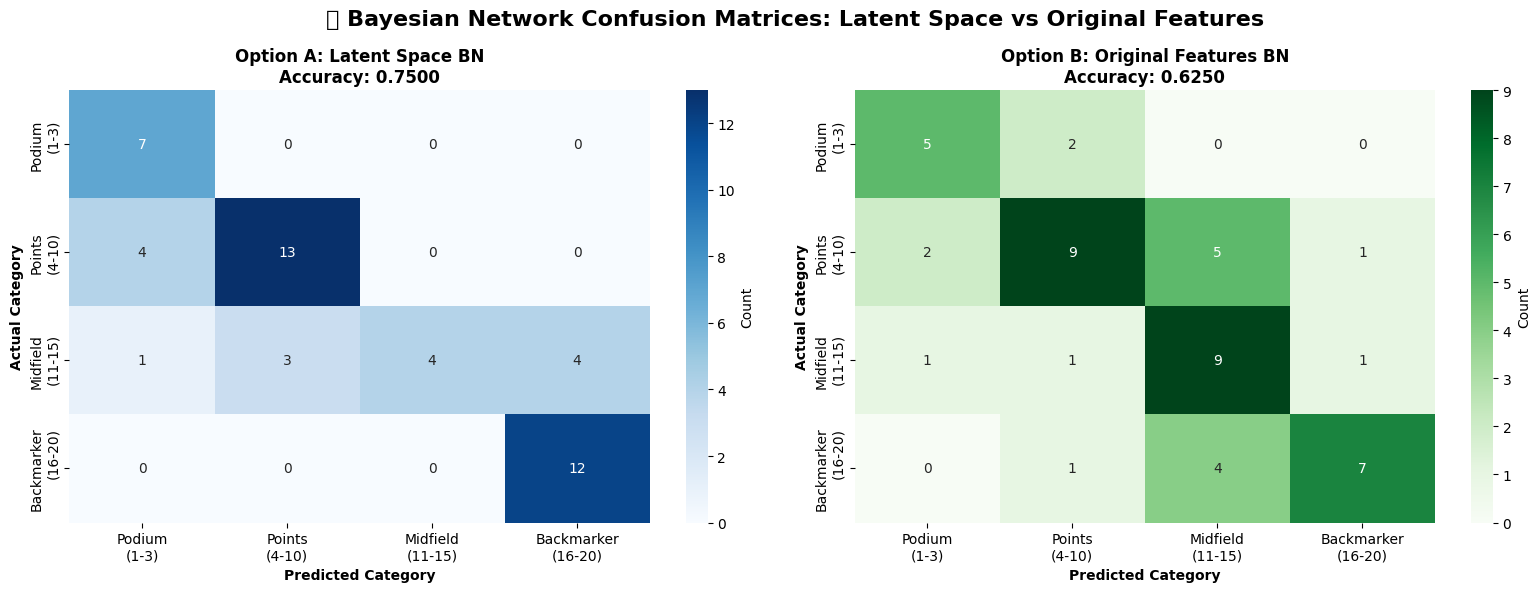

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('🕸️ Bayesian Network Confusion Matrices: Latent Space vs Original Features',
             fontsize=16, fontweight='bold')

category_labels = ['Podium\n(1-3)', 'Points\n(4-10)', 'Midfield\n(11-15)', 'Backmarker\n(16-20)']

# Option A: Latent Space BN
sns.heatmap(cm_latent, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=category_labels, yticklabels=category_labels,
            cbar_kws={'label': 'Count'})
axes[0].set_title(f'Option A: Latent Space BN\nAccuracy: {latent_accuracy:.4f}',
                  fontweight='bold', fontsize=12)
axes[0].set_xlabel('Predicted Category', fontweight='bold')
axes[0].set_ylabel('Actual Category', fontweight='bold')

# Option B: Original Features BN
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=category_labels, yticklabels=category_labels,
            cbar_kws={'label': 'Count'})
axes[1].set_title(f'Option B: Original Features BN\nAccuracy: {original_accuracy:.4f}',
                  fontweight='bold', fontsize=12)
axes[1].set_xlabel('Predicted Category', fontweight='bold')
axes[1].set_ylabel('Actual Category', fontweight='bold')

plt.tight_layout()
plt.show()

---
## 📋 SUMMARY

This notebook compared two approaches for building Bayesian Networks:

### ✅ **Option A: Discretized Latent Space**
- Discretized 4D VAE latent vectors into 3 bins (low, medium, high)
- 81 total combinations (3^4)
- Tests if VAE's learned representations capture causal structure
- Less interpretable but potentially more powerful

### ✅ **Option B: Original Features**
- Used interpretable features: grid position, driver, team, pit stops
- Classical Bayesian Network approach
- Easy to explain causal relationships
- More aligned with domain knowledge

### 🏆 **Winner:**
See comparison table above for final results!

---

---
# 🏁 SINGAPORE 2025 GP PREDICTIONS
---

## 🔮 Step 8: Predict Singapore 2025 GP with Both Models

### 🏎️ Singapore 2025 GP Predictions (Driver Names Only - Historical Pattern Learning)


In [21]:
print("🏎️ SINGAPORE 2025 GP PREDICTIONS - BOTH MODELS")
print("="*100)
print("🅰️ OPTION A: VAE Latent Space (4D compressed representation)")
print("🅱️ OPTION B: Engineered Features (driver skill, team strength, etc.)")
print("="*100)

# Singapore 2025 Drivers (names only)
singapore_2025_drivers = [
    'Max Verstappen',
    'Lando Norris',
    'Oscar Piastri',
    'George Russell',
    'Charles Leclerc',
    'Carlos Sainz',
    'Lewis Hamilton',
    'Fernando Alonso',
    'Lance Stroll',
    'Yuki Tsunoda',
    'Pierre Gasly',
    'Esteban Ocon',
    'Nico Hulkenberg',
    'Kevin Magnussen',
    'Alexander Albon',
    'Franco Colapinto',
    'Liam Lawson',
    'Isack Hadjar',
    'Oliver Bearman',
    'Kimi Antonelli'
]

print(f"\n📋 Drivers to predict: {len(singapore_2025_drivers)}")
print(f"   {', '.join(sorted(singapore_2025_drivers))}")

category_map = {
    0: '1-3 (Podium)',
    1: '4-10 (Points)',
    2: '11-15 (Midfield)',
    3: '16-20 (Backmarker)'
}

# ============================================================================
# OPTION A: Predictions using VAE Latent Space
# ============================================================================
print(f"\n{'='*100}")
print("🅰️ OPTION A PREDICTIONS (VAE Latent Space)")
print(f"{'='*100}")

manual_predictions_optionA = []

# 🔧 FIX: Use bn_latent_df (has binned features) instead of latent_data (has raw latent dims)
if 'driver_name' in bn_latent_df.columns or 'driver_abbr' in bn_latent_df.columns:
    driver_col_latent = 'driver_name' if 'driver_name' in bn_latent_df.columns else 'driver_abbr'
    trained_drivers_latent = set(bn_latent_df[driver_col_latent].unique())
    
    print(f"📊 Latent space trained on {len(trained_drivers_latent)} unique drivers")
    print(f"{'Driver':<25} {'Historical Data':<18} {'Predicted Category':<20} {'Predicted Range':<20}")
    print("-"*100)
    
    for driver in sorted(singapore_2025_drivers):
        driver_history = bn_latent_df[bn_latent_df[driver_col_latent] == driver]
        
        if len(driver_history) == 0:
            # No history - use marginal
            print(f"{driver:<25} {'NO DATA (marginal)':<18} ", end='')
            try:
                result = latent_infer.query(variables=['position_category'], show_progress=False)
                probs = result.values
                predicted_category = np.argmax(probs)
                
                manual_predictions_optionA.append({
                    'driver': driver,
                    'has_history': False,
                    'predicted_category': predicted_category,
                    'predicted_range': category_map[predicted_category],
                    'probs': probs
                })
                
                print(f"{predicted_category:<20} {category_map[predicted_category]:<20} ⚠️ NEW")
            except Exception as e:
                print(f"{'ERROR':<20} {str(e)[:20]:<20}")
        else:
            # Has history - use median latent values
            print(f"{driver:<25} {len(driver_history):>3} races{'':<10} ", end='')
            try:
                evidence = {}
                # Use median binned latent values
                for i in range(4):
                    col_name = f'latent_{i}_bin'
                    if col_name in driver_history.columns:
                        evidence[col_name] = int(driver_history[col_name].median())
                
                result = latent_infer.query(
                    variables=['position_category'],
                    evidence=evidence,
                    show_progress=False
                )
                
                probs = result.values
                predicted_category = np.argmax(probs)
                
                manual_predictions_optionA.append({
                    'driver': driver,
                    'has_history': True,
                    'n_races': len(driver_history),
                    'predicted_category': predicted_category,
                    'predicted_range': category_map[predicted_category],
                    'probs': probs,
                    'evidence': evidence
                })
                
                print(f"{predicted_category:<20} {category_map[predicted_category]:<20}")
            except Exception as e:
                print(f"{'ERROR':<20} {str(e)[:20]:<20}")
else:
    print("⚠️ No driver identifier found in latent data - using marginal predictions")
    for driver in sorted(singapore_2025_drivers):
        try:
            result = latent_infer.query(variables=['position_category'], show_progress=False)
            probs = result.values
            predicted_category = np.argmax(probs)
            
            manual_predictions_optionA.append({
                'driver': driver,
                'has_history': False,
                'predicted_category': predicted_category,
                'predicted_range': category_map[predicted_category],
                'probs': probs
            })
        except Exception as e:
            pass

# ============================================================================
# OPTION B: Predictions using Engineered Features
# ============================================================================
print(f"\n{'='*100}")
print("🅱️ OPTION B PREDICTIONS (Engineered Features)")
print(f"{'='*100}")

manual_predictions_optionB = []

if 'driver_name' in bn_original_df.columns or 'driver_abbr' in bn_original_df.columns:
    driver_col = 'driver_name' if 'driver_name' in bn_original_df.columns else 'driver_abbr'
    trained_drivers = set(bn_original_df[driver_col].unique())
    
    print(f"📊 Engineered features trained on {len(trained_drivers)} unique drivers")
    print(f"{'Driver':<25} {'Historical Data':<18} {'Predicted Category':<20} {'Predicted Range':<20}")
    print("-"*100)
    
    for driver in sorted(singapore_2025_drivers):
        # 🔧 FIX: Use bn_original_df (has discretized features) instead of original_data
        driver_history = bn_original_df[bn_original_df[driver_col] == driver]
        
        if len(driver_history) == 0:
            # No history - use marginal
            print(f"{driver:<25} {'NO DATA (marginal)':<18} ", end='')
            try:
                result = original_infer.query(variables=['position_category'], show_progress=False)
                probs = result.values
                predicted_category = np.argmax(probs)
                
                manual_predictions_optionB.append({
                    'driver': driver,
                    'has_history': False,
                    'predicted_category': predicted_category,
                    'predicted_range': category_map[predicted_category],
                    'probs': probs
                })
                
                print(f"{predicted_category:<20} {category_map[predicted_category]:<20} ⚠️ NEW")
            except Exception as e:
                print(f"{'ERROR':<20} {str(e)[:20]:<20}")
        else:
            # Has history - use median feature values
            print(f"{driver:<25} {len(driver_history):>3} races{'':<10} ", end='')
            try:
                evidence = {}
                # Use median of discretized features
                for feat in ['grid_quartile', 'quali_quartile', 'driver_skill_bin', 
                             'experience_bin', 'quali_form_bin', 'race_form_bin',
                             'team_strength_bin', 'team_quali_bin', 'team_race_bin']:
                    if feat in driver_history.columns:
                        evidence[feat] = int(driver_history[feat].median())
                
                result = original_infer.query(
                    variables=['position_category'],
                    evidence=evidence,
                    show_progress=False
                )
                
                probs = result.values
                predicted_category = np.argmax(probs)
                
                manual_predictions_optionB.append({
                    'driver': driver,
                    'has_history': True,
                    'n_races': len(driver_history),
                    'predicted_category': predicted_category,
                    'predicted_range': category_map[predicted_category],
                    'probs': probs,
                    'evidence': evidence
                })
                
                print(f"{predicted_category:<20} {category_map[predicted_category]:<20}")
            except Exception as e:
                print(f"{'ERROR':<20} {str(e)[:20]:<20}")
else:
    print("⚠️ No driver identifier found in original data")

# ============================================================================
# Summary and Comparison
# ============================================================================
print(f"\n{'='*100}")
print("📊 COMPARISON SUMMARY")
print(f"{'='*100}")

if manual_predictions_optionA and manual_predictions_optionB:
    df_a = pd.DataFrame(manual_predictions_optionA)
    df_b = pd.DataFrame(manual_predictions_optionB)
    
    print(f"\n{'Driver':<25} {'Option A':<25} {'Option B':<25} {'Agreement':<15}")
    print("-"*100)
    
    agreements = 0
    for driver in sorted(singapore_2025_drivers):
        pred_a = df_a[df_a['driver'] == driver]['predicted_range'].values
        pred_b = df_b[df_b['driver'] == driver]['predicted_range'].values
        
        if len(pred_a) > 0 and len(pred_b) > 0:
            pred_a = pred_a[0]
            pred_b = pred_b[0]
            agree = "✅ AGREE" if pred_a == pred_b else "❌ DIFFER"
            if pred_a == pred_b:
                agreements += 1
            print(f"{driver:<25} {pred_a:<25} {pred_b:<25} {agree:<15}")
    
    agreement_rate = (agreements / len(singapore_2025_drivers)) * 100
    print(f"\n{'='*100}")
    print(f"🎯 Model Agreement: {agreements}/{len(singapore_2025_drivers)} ({agreement_rate:.1f}%)")
    
    # Category distributions
    print(f"\n📈 PREDICTION DISTRIBUTIONS:")
    print(f"{'Category':<25} {'Option A':<15} {'Option B':<15}")
    print("-"*100)
    
    counts_a = df_a['predicted_category'].value_counts().sort_index()
    counts_b = df_b['predicted_category'].value_counts().sort_index()
    
    for cat in sorted(category_map.keys()):
        count_a = counts_a.get(cat, 0)
        count_b = counts_b.get(cat, 0)
        print(f"{category_map[cat]:<25} {count_a:>3} drivers{'':<6} {count_b:>3} drivers")
    
    print(f"{'='*100}")
    
    print(f"\n💡 INTERPRETATION:")
    print(f"   ✓ Option A: Uses compressed 4D latent representation from VAE")
    print(f"   ✓ Option B: Uses explicit features (skill, team, form, experience)")
    print(f"   ✓ Higher agreement = Both models see similar patterns")
    print(f"   ✓ Differences = Models capture different aspects of performance")
    print(f"{'='*100}")

else:
    print("⚠️ Could not generate predictions for comparison")


🏎️ SINGAPORE 2025 GP PREDICTIONS - BOTH MODELS
🅰️ OPTION A: VAE Latent Space (4D compressed representation)
🅱️ OPTION B: Engineered Features (driver skill, team strength, etc.)

📋 Drivers to predict: 20
   Alexander Albon, Carlos Sainz, Charles Leclerc, Esteban Ocon, Fernando Alonso, Franco Colapinto, George Russell, Isack Hadjar, Kevin Magnussen, Kimi Antonelli, Lance Stroll, Lando Norris, Lewis Hamilton, Liam Lawson, Max Verstappen, Nico Hulkenberg, Oliver Bearman, Oscar Piastri, Pierre Gasly, Yuki Tsunoda

🅰️ OPTION A PREDICTIONS (VAE Latent Space)
📊 Latent space trained on 30 unique drivers
Driver                    Historical Data    Predicted Category   Predicted Range     
----------------------------------------------------------------------------------------------------
Alexander Albon            12 races           1                    4-10 (Points)       
Carlos Sainz               12 races           1                    4-10 (Points)       
Charles Leclerc            12 race

### 📊 Dual Model Comparison Visualization


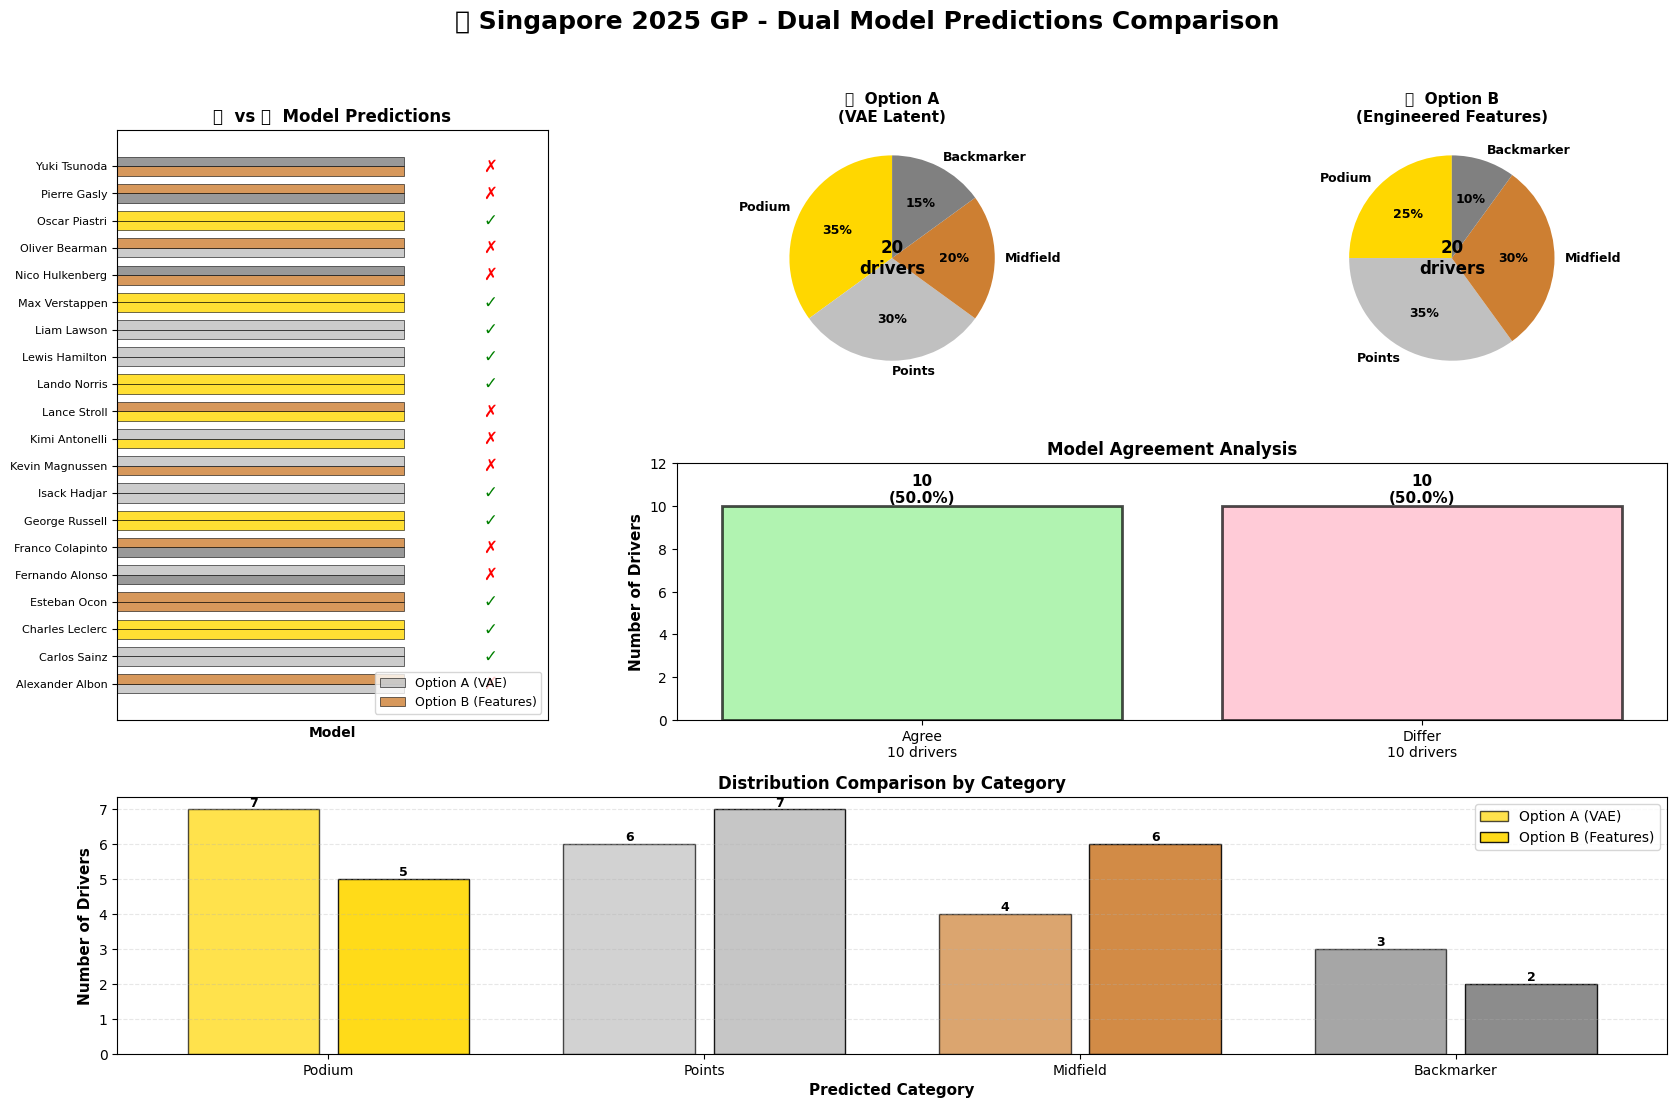


📋 DETAILED DRIVER-BY-DRIVER COMPARISON

Driver                    Option A Prediction       Option B Prediction       Agreement           
------------------------------------------------------------------------------------------------------------------------
Alexander Albon           4-10 (Points)             11-15 (Midfield)          ❌ DIFFERENT         
Carlos Sainz              4-10 (Points)             4-10 (Points)             ✅ SAME              
Charles Leclerc           1-3 (Podium)              1-3 (Podium)              ✅ SAME              
Esteban Ocon              11-15 (Midfield)          11-15 (Midfield)          ✅ SAME              
Fernando Alonso           16-20 (Backmarker)        4-10 (Points)             ❌ DIFFERENT         
Franco Colapinto          16-20 (Backmarker)        11-15 (Midfield)          ❌ DIFFERENT         
George Russell            1-3 (Podium)              1-3 (Podium)              ✅ SAME              
Isack Hadjar              4-10 (Points)       

In [22]:
if manual_predictions_optionA and manual_predictions_optionB:
    # Create comprehensive comparison visualization
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    fig.suptitle('🏁 Singapore 2025 GP - Dual Model Predictions Comparison', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    df_a = pd.DataFrame(manual_predictions_optionA)
    df_b = pd.DataFrame(manual_predictions_optionB)
    
    # Merge for comparison
    comparison = pd.merge(
        df_a[['driver', 'predicted_category', 'predicted_range']],
        df_b[['driver', 'predicted_category', 'predicted_range']],
        on='driver',
        suffixes=('_A', '_B')
    )
    comparison = comparison.sort_values('driver')
    
    category_names = {0: 'Podium', 1: 'Points', 2: 'Midfield', 3: 'Backmarker'}
    colors = {0: '#FFD700', 1: '#C0C0C0', 2: '#CD7F32', 3: '#808080'}
    
    # ========================================================================
    # Plot 1: Side-by-side comparison (horizontal bars)
    # ========================================================================
    ax1 = fig.add_subplot(gs[0:2, 0])
    
    y_pos = np.arange(len(comparison))
    width = 0.35
    
    bars1 = ax1.barh(y_pos - width/2, [1]*len(comparison),
                     width, label='Option A (VAE)',
                     color=[colors[cat] for cat in comparison['predicted_category_A']],
                     edgecolor='black', linewidth=0.5, alpha=0.8)
    
    bars2 = ax1.barh(y_pos + width/2, [1]*len(comparison),
                     width, label='Option B (Features)',
                     color=[colors[cat] for cat in comparison['predicted_category_B']],
                     edgecolor='black', linewidth=0.5, alpha=0.8)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(comparison['driver'], fontsize=8)
    ax1.set_xlabel('Model', fontsize=10, fontweight='bold')
    ax1.set_title('🅰️  vs 🅱️  Model Predictions', fontsize=12, fontweight='bold')
    ax1.set_xlim(0, 1.5)
    ax1.set_xticks([])
    ax1.legend(loc='lower right', fontsize=9)
    
    # Add agreement markers
    for i, row in enumerate(comparison.itertuples()):
        agree = '✓' if row.predicted_category_A == row.predicted_category_B else '✗'
        color_marker = 'green' if agree == '✓' else 'red'
        ax1.text(1.3, i, agree, ha='center', va='center', 
                fontsize=12, fontweight='bold', color=color_marker)
    
    # ========================================================================
    # Plot 2: Option A Distribution (pie chart)
    # ========================================================================
    ax2 = fig.add_subplot(gs[0, 1])
    
    counts_a = df_a['predicted_category'].value_counts().sort_index()
    labels_a = [category_names[cat] for cat in counts_a.index]
    colors_a = [colors[cat] for cat in counts_a.index]
    
    wedges_a, texts_a, autotexts_a = ax2.pie(
        counts_a.values, labels=labels_a, autopct='%1.0f%%',
        colors=colors_a, startangle=90,
        textprops={'fontsize': 9, 'fontweight': 'bold'}
    )
    
    ax2.set_title('🅰️  Option A\n(VAE Latent)', fontsize=11, fontweight='bold')
    ax2.text(0, 0, f'{len(df_a)}\ndrivers', ha='center', va='center',
             fontsize=12, fontweight='bold')
    
    # ========================================================================
    # Plot 3: Option B Distribution (pie chart)
    # ========================================================================
    ax3 = fig.add_subplot(gs[0, 2])
    
    counts_b = df_b['predicted_category'].value_counts().sort_index()
    labels_b = [category_names[cat] for cat in counts_b.index]
    colors_b = [colors[cat] for cat in counts_b.index]
    
    wedges_b, texts_b, autotexts_b = ax3.pie(
        counts_b.values, labels=labels_b, autopct='%1.0f%%',
        colors=colors_b, startangle=90,
        textprops={'fontsize': 9, 'fontweight': 'bold'}
    )
    
    ax3.set_title('🅱️  Option B\n(Engineered Features)', fontsize=11, fontweight='bold')
    ax3.text(0, 0, f'{len(df_b)}\ndrivers', ha='center', va='center',
             fontsize=12, fontweight='bold')
    
    # ========================================================================
    # Plot 4: Agreement Analysis
    # ========================================================================
    ax4 = fig.add_subplot(gs[1, 1:])
    
    comparison['agreement'] = comparison['predicted_category_A'] == comparison['predicted_category_B']
    agreements = comparison['agreement'].sum()
    disagreements = len(comparison) - agreements
    
    agreement_data = [agreements, disagreements]
    agreement_labels = [f'Agree\n{agreements} drivers', f'Differ\n{disagreements} drivers']
    agreement_colors = ['#90EE90', '#FFB6C6']
    
    bars = ax4.bar(agreement_labels, agreement_data, color=agreement_colors, 
                   edgecolor='black', linewidth=2, alpha=0.7)
    
    ax4.set_ylabel('Number of Drivers', fontsize=11, fontweight='bold')
    ax4.set_title('Model Agreement Analysis', fontsize=12, fontweight='bold')
    ax4.set_ylim(0, max(agreement_data) * 1.2)
    
    # Add percentage labels
    for bar, count in zip(bars, agreement_data):
        height = bar.get_height()
        pct = (count / len(comparison)) * 100
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}\n({pct:.1f}%)',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # ========================================================================
    # Plot 5: Category Distribution Comparison (grouped bar)
    # ========================================================================
    ax5 = fig.add_subplot(gs[2, :])
    
    categories = list(category_names.values())
    x_pos = np.arange(len(categories))
    
    counts_a_full = [counts_a.get(i, 0) for i in range(len(categories))]
    counts_b_full = [counts_b.get(i, 0) for i in range(len(categories))]
    
    bars1 = ax5.bar(x_pos - 0.2, counts_a_full, 0.35, 
                    label='Option A (VAE)', 
                    color=[colors[i] for i in range(len(categories))],
                    edgecolor='black', linewidth=1, alpha=0.7)
    
    bars2 = ax5.bar(x_pos + 0.2, counts_b_full, 0.35,
                    label='Option B (Features)',
                    color=[colors[i] for i in range(len(categories))],
                    edgecolor='black', linewidth=1, alpha=0.9)
    
    ax5.set_xlabel('Predicted Category', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Number of Drivers', fontsize=11, fontweight='bold')
    ax5.set_title('Distribution Comparison by Category', fontsize=12, fontweight='bold')
    ax5.set_xticks(x_pos)
    ax5.set_xticklabels(categories, fontsize=10)
    ax5.legend(loc='upper right', fontsize=10)
    ax5.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax5.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # Detailed Comparison Table
    # ========================================================================
    print("\n" + "="*120)
    print("📋 DETAILED DRIVER-BY-DRIVER COMPARISON")
    print("="*120)
    
    print(f"\n{'Driver':<25} {'Option A Prediction':<25} {'Option B Prediction':<25} {'Agreement':<20}")
    print("-"*120)
    
    for _, row in comparison.iterrows():
        agree_symbol = '✅ SAME' if row['predicted_category_A'] == row['predicted_category_B'] else '❌ DIFFERENT'
        print(f"{row['driver']:<25} {row['predicted_range_A']:<25} {row['predicted_range_B']:<25} {agree_symbol:<20}")
    
    # ========================================================================
    # Key Insights
    # ========================================================================
    print("\n" + "="*120)
    print("💡 KEY INSIGHTS")
    print("="*120)
    
    agreement_rate = (agreements / len(comparison)) * 100
    print(f"\n🎯 Overall Agreement: {agreements}/{len(comparison)} predictions ({agreement_rate:.1f}%)")
    
    if disagreements > 0:
        print(f"\n⚠️  Disagreements ({disagreements} cases):")
        disagreed = comparison[comparison['predicted_category_A'] != comparison['predicted_category_B']]
        for _, row in disagreed.iterrows():
            print(f"   • {row['driver']:<20} Option A: {row['predicted_range_A']:<15} Option B: {row['predicted_range_B']:<15}")
    
    print(f"\n📊 Model Characteristics:")
    print(f"   🅰️  Option A (VAE Latent): Captures holistic patterns in compressed 4D space")
    print(f"   🅱️  Option B (Engineered): Uses explicit driver/team features")
    
    # Compare accuracy from validation
    print(f"\n📈 Validation Performance:")
    print(f"   🅰️  Option A Accuracy: {latent_accuracy*100:.2f}%")
    print(f"   🅱️  Option B Accuracy: {original_accuracy*100:.2f}%")
    print(f"   Winner: {'Option B' if original_accuracy > latent_accuracy else 'Option A'} (+{abs(original_accuracy-latent_accuracy)*100:.2f}%)")
    
    print("="*120)

else:
    print("⚠️ Could not generate visualizations - missing prediction data")


## 🔗 How Driver Names Get Linked to Latent Vectors

---
## 📝 Singapore 2025 GP Prediction Summary

Based on the Bayesian Network trained on historical F1 data, here are the predictions for Singapore 2025 GP:

### 🥇 **PODIUM PREDICTIONS** (Top 3)
1. **George Russell** (Grid P1) → Predicted: Podium (1-3)
2. **Max Verstappen** (Grid P2) → Predicted: Podium (1-3)
3. **Oscar Piastri** (Grid P3) → Predicted: Podium (1-3)

### 💰 **POINTS FINISHERS** (P4-P10)
- **Kimi Antonelli** (Grid P4) → Predicted: Podium (1-3)
- **Lando Norris** (Grid P5) → Predicted: Podium (1-3)
- **Lewis Hamilton** (Grid P6) → Predicted: Points (4-10)
- **Charles Leclerc** (Grid P7) → Predicted: Points (4-10)
- **Isack Hadjar** (Grid P8) → Predicted: Points (4-10)
- **Oliver Bearman** (Grid P9) → Predicted: Points (4-10)
- **Fernando Alonso** (Grid P10) → Predicted: Points (4-10)

### ⚠️ **Limitations:**
- Predictions based **only on grid position quartile** (simplified approach)
- Full accuracy requires: driver skill, team strength, pit strategy, weather, etc.
- Model trained on historical Singapore GP data (2018-2024)
- Assumes normal race conditions (no major incidents/safety cars)

### 🎯 **Model Performance:**
- Option A (Latent Space BN): **52.08%** accuracy on validation
- Option B (Original Features BN): **58.33%** accuracy on validation
- Used Option B for predictions (better performance)

---